# Bias Analysis - IMV Task

## ShapleyVIC installation

In [ ]:
! pip install git+"https://github.com/nliulab/ShapleyVIC#egg=ShapleyVIC&subdirectory=python"

## imports

In [1]:
from datetime import timedelta
from google.cloud import bigquery
import pandas as pd
import numpy as np
import re
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
from pandas.io import gbq
from sklearn.model_selection import train_test_split
import pickle
from sklearn.impute import SimpleImputer
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, f1_score
import ShapleyVIC
from ShapleyVIC import _util, model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## ShapleyVIC modification

In [ ]:
# see folders in ShapleyVIC
!ls /usr/local/lib/python3.12/dist-packages/ShapleyVIC

In [4]:
!grep -r "sample_w" /usr/local/lib/python3.12/dist-packages/ShapleyVIC

In [ ]:
file_path = "/usr/local/lib/python3.12/dist-packages/ShapleyVIC/model.py"

# Read the file
with open(file_path, "r") as f:
    text = f.read()

# --- First replacement: add sample_w to __init__ ---
text = text.replace(
    'class models:\n    def __init__(self, x, y, output_dir, outcome_type="binary", ordinal_link="logit", criterion="loss", epsilon = 0.05, x_names_cat=None, save_data=True):',
    'class models:\n    def __init__(self, x, y, output_dir, outcome_type="binary", ordinal_link="logit",\n                 criterion="loss", epsilon=0.05, x_names_cat=None, save_data=True,\n                 sample_w=None):'
)

# --- Second replacement: add sample_w logic for binary/continuous ---
text = text.replace(
    '''if outcome_type == "binary":
            x_with_constant = sm.add_constant(x_dm)
            m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial())
            m = m0.fit()
        elif outcome_type == "continuous":
            x_with_constant = sm.add_constant(x_dm)
            m0 = sm.OLS(y, x_with_constant)
            m = m0.fit()''',
    '''if outcome_type == "binary":
            x_with_constant = sm.add_constant(x_dm)
            if sample_w is not None:
                m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial(), freq_weights=sample_w)
            else:
                m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial())
            m = m0.fit()
        elif outcome_type == "continuous":
            x_with_constant = sm.add_constant(x_dm)
            if sample_w is not None:
                m0 = sm.WLS(y, x_with_constant, weights=sample_w)
            else:
                m0 = sm.OLS(y, x_with_constant)
            m = m0.fit()'''
)

# Save back to file
with open(file_path, "w") as f:
    f.write(text)

print("File updated successfully with sample_w support!")


In [ ]:
!grep -r "sample_w" /usr/local/lib/python3.12/dist-packages/ShapleyVIC

# IMV Task Dataset

## Train-val-test split

In [2]:
cohort = pd.read_csv("cohort.csv")

In [3]:
# Create 70/10/20 split
dat_train, temp_df = train_test_split(cohort, test_size=0.3, random_state=42)
dat_expl, dat_test = train_test_split(temp_df, test_size=2/3, random_state=42)

In [4]:
print('Training dataset size = ', len(dat_train))
print('Validation dataset size = ', len(dat_expl))
print('Testing dataset size = ', len(dat_test))

Training dataset size =  39305
Validation dataset size =  5615
Testing dataset size =  11230


## Missing Value Imputation

In [5]:
vitals_cols = ['temperature','heart_rate','resp_rate','sbp','dbp','sofa_24hours']
imputer = SimpleImputer(strategy='median') #median for continuous and numeric

dat_train[vitals_cols] = imputer.fit_transform(dat_train[vitals_cols])
dat_expl[vitals_cols] = imputer.transform(dat_expl[vitals_cols])
dat_test[vitals_cols] = imputer.transform(dat_test[vitals_cols])

In [6]:
conditions = {
    'hypertension': ['I10', 'I11', 'I12', 'I13'],
    'congestive_heart_failure': ['I50'],
    'copd': ['J44'],
    'asthma': ['J45'],
    'coronary_artery_disease': ['I25'],
    'chronic_kidney_disease': ['N18'],
    'diabetes': ['E10', 'E11'],
    'connective_tissue_disease': ['M05', 'M06']
}

# Bias Analysis

## Balanced weights on label

Weigh up minority label (IMV) and weigh down majority label (No IMV)

#STATS MODELS

In [7]:
def find_optimal_cutoff(target, predicted, method="auc"):
    """Find the optimal probability cutoff point for a classification model related to event rate.

    Args:
        target (array-like): True labels.
        predicted (array-like): Predicted scores or probabilities.
        method (str, optional): Method for finding the optimal cutoff. Default is 'auc'.

    Returns:
        list: List of optimal cutoff values.
    """
    if method == "auc":
        fpr, tpr, threshold = roc_curve(target, predicted)
        i = np.arange(len(tpr))
        roc = pd.DataFrame(
            {
                "tf": pd.Series(tpr + (1 - fpr), index=i),
                "threshold": pd.Series(threshold, index=i),
            }
        )
        roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[::-1][:1]]
    elif method == "pr-auc":
        precision, recall, threshold = precision_recall_curve(target, predicted)
        i = np.arange(len(precision))
        prc = pd.DataFrame(
            {
                "tf": pd.Series(tpr - (1 - fpr), index=i),
                "threshold": pd.Series(threshold, index=i),
            }
        )
        prc_t = prc.iloc[(prc.tf - 0).abs().argsort()[:1]]

    return list(roc_t["threshold"])

In [8]:
# ===== DEFINE FEATURES (exactly as FAIM does) =====
y_name = 'imv'
colnames = ['age', 'sex', 'race', 'elective_admission',
            'sofa_24hours', 'charlson_comorbidity_index',
            'heart_rate', 'sbp', 'dbp', 'resp_rate', 'temperature'] + list(conditions.keys())
x_names_cat = ["sex", "race"]

# ===== COMPUTE BALANCED CLASS WEIGHTS =====
y_train = dat_train[y_name].astype(int)
y_test = dat_test[y_name].astype(int)

n_samples = len(y_train)
classes, counts = np.unique(y_train, return_counts=True)
class_weight_balanced = {
    cls: n_samples / (len(classes) * cnt)
    for cls, cnt in zip(classes, counts)
}
sample_weights = np.array([class_weight_balanced[cls] for cls in y_train])

print(f"✓ Class weights: {class_weight_balanced}")
print(f"✓ Sample weight range: [{sample_weights.min():.2f}, {sample_weights.max():.2f}]")

# ===== TRAIN MODEL USING SHAPLEY VIC =====
# Use raw data (NO preprocessing) - ShapleyVIC does it internally
x_train = dat_train[colnames].copy()

# Use ShapleyVIC's model class with same criterion as FAIM
model_obj = model.models(
    x=x_train,  # Raw data, ShapleyVIC preprocesses internally
    y=y_train,
    x_names_cat=x_names_cat,
    output_dir='bias_analysis_output',
    criterion='auc',  # Match FAIM
    sample_w=sample_weights
)

# Get the optimal model
baseline_results = model_obj.model_optim
print("\n" + "="*60)
print("BASELINE MODEL (ShapleyVIC with criterion='auc')")
print("="*60)
print(f"AIC: {baseline_results.aic:.2f}")
print(f"Log-Likelihood: {baseline_results.llf:.2f}")
print(f"Converged: {baseline_results.converged}")
print(f"Number of features: {len(baseline_results.params)}")

# ===== PREPARE TEST DATA FOR PREDICTIONS =====
# ShapleyVIC preprocessed the training data internally
# We need to apply THE SAME preprocessing to test data

# Get the processed feature names from the model
trained_features = baseline_results.params.index.tolist()
print(f"\n✓ Trained features ({len(trained_features)}): {trained_features[:5]}...")

# Apply ShapleyVIC preprocessing to test data
x_test_raw = dat_test[colnames].copy()
x_test_dm, x_test_groups = _util.model_matrix(x=x_test_raw, x_names_cat=x_names_cat)
X_test = sm.add_constant(x_test_dm, has_constant='add')
X_test = X_test.astype(float)

# Ensure columns match training data
# (In case test data has different category levels)
for col in trained_features:
    if col not in X_test.columns:
        X_test[col] = 0.0

# Reorder to match training
X_test = X_test[trained_features]

print(f"✓ X_test shape: {X_test.shape}")
print(f"✓ X_test columns match training: {list(X_test.columns) == trained_features}")

# ===== GENERATE PREDICTIONS =====
y_pred_prob = baseline_results.predict(X_test)

# Use optimal threshold (same as FAIM)
optimal_threshold = find_optimal_cutoff(y_test, y_pred_prob, method="auc")[0]
y_pred_bin = (y_pred_prob > optimal_threshold).astype(int)

dat_test = dat_test.copy()
dat_test["pred_imv"] = y_pred_bin
dat_test["pred_imv_prob"] = y_pred_prob

print(f"\n✓ Optimal threshold: {optimal_threshold:.4f}")
print(f"✓ Predictions generated: {len(y_pred_bin)}")

# ===== VERIFY PREDICTIONS MAKE SENSE =====
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score

print("\n" + "="*60)
print("PREDICTION VERIFICATION")
print("="*60)
print(f"Overall AUC: {roc_auc_score(y_test, y_pred_prob):.3f}")
print(f"Overall TPR: {recall_score(y_test, y_pred_bin):.3f}")
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred_bin):.3f}")
print(f"Positive predictions: {y_pred_bin.sum()} ({y_pred_bin.mean():.1%})")
print(f"Actual positives: {y_test.sum()} ({y_test.mean():.1%})")

✓ Class weights: {np.int64(0): np.float64(0.7527674570038687), np.int64(1): np.float64(1.489051371419912)}
✓ Sample weight range: [0.75, 1.49]

BASELINE MODEL (ShapleyVIC with criterion='auc')
AIC: 41387.77
Log-Likelihood: -20670.88
Converged: True
Number of features: 23

✓ Trained features (23): ['const', 'age', 'sex_Female', 'race_Asian', 'race_Black']...
✓ X_test shape: (11230, 23)
✓ X_test columns match training: True

✓ Optimal threshold: 0.4192
✓ Predictions generated: 11230

PREDICTION VERIFICATION
Overall AUC: 0.830
Overall TPR: 0.812
Overall Accuracy: 0.741
Positive predictions: 5242 (46.7%)
Actual positives: 3732 (33.2%)


In [9]:
def fairness_with_reference(df, group_var, y_true_col, y_pred_col, reference_group):
    # iterate only over non-null groups to avoid boolean comparisons with nan
    groups = df[group_var].dropna().unique()
    results = []

    # We'll collect lists for gaps too, but we will read from the df later to avoid mismatch
    for g in groups:
        idx = df[group_var] == g
        y_t = df.loc[idx, y_true_col]
        y_p = df.loc[idx, y_pred_col]

        if len(y_t) == 0:
            continue

        # confusion_matrix with labels=[0,1] forces a 2x2 matrix even if one class missing
        tn, fp, fn, tp = confusion_matrix(y_t, y_p, labels=[0, 1]).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
        sr = y_p.mean() if len(y_p) > 0 else np.nan

        # preserve your original behaviour: if there are no positives in y_t, produce np.nan
        f1 = f1_score(y_t, y_p) if np.sum(y_t) > 0 else np.nan

        ber = 0.5 * ( (fpr if not np.isnan(fpr) else 0) + (fnr if not np.isnan(fnr) else 0) ) \
              if (not np.isnan(fpr) or not np.isnan(fnr)) else np.nan

        results.append({
            "group": g,
            "n_samples": len(y_t),
            "TPR": tpr,
            "FPR": fpr,
            "TNR": tnr,
            "FNR": fnr,
            "Accuracy": acc,
            "SR": sr,
            "F1": f1,
            "BER": ber
        })

    # make the group the index, and do NOT keep a duplicate column
    df_group_metrics = (
        pd.DataFrame(results)
        .set_index("group", drop=True)   # group -> index, column removed
        .round(4)
    )

    # ----------- MAKE SURE REFERENCE GROUP EXISTS -----------
    if reference_group not in df_group_metrics.index:
        raise ValueError(f"Reference group '{reference_group}' not found in {group_var}")

    ref_row = df_group_metrics.loc[reference_group]

    # ----------- EQUALIZED ODDS (choose which dominates) -----------
    # read TPR / FPR arrays directly from the dataframe (keeps order consistent with index)
    tprs = df_group_metrics["TPR"].values
    fprs = df_group_metrics["FPR"].values

    tpr_gap = np.nanmax(tprs) - np.nanmin(tprs)
    fpr_gap = np.nanmax(fprs) - np.nanmin(fprs)

    if tpr_gap >= fpr_gap:
        eo_values = tprs
        eo_type = "TPR"
    else:
        eo_values = fprs
        eo_type = "FPR"

    eo_min_idx = np.nanargmin(eo_values)
    eo_max_idx = np.nanargmax(eo_values)

    eo_min_value = float(eo_values[eo_min_idx])
    eo_max_value = float(eo_values[eo_max_idx])

    eo_min_group = df_group_metrics.index[eo_min_idx]
    eo_max_group = df_group_metrics.index[eo_max_idx]

    equalized_odds = eo_max_value - eo_min_value

    ref_eo_value = float(ref_row[eo_type])
    ref_vs_min_gap = ref_eo_value - eo_min_value

    # ----------- EQUAL OPPORTUNITY -----------
    tpr_min_idx = np.nanargmin(tprs)
    tpr_max_idx = np.nanargmax(tprs)

    tpr_min_val = float(tprs[tpr_min_idx])
    tpr_max_val = float(tprs[tpr_max_idx])

    tpr_min_group = df_group_metrics.index[tpr_min_idx]
    tpr_max_group = df_group_metrics.index[tpr_max_idx]

    equal_opportunity = tpr_max_val - tpr_min_val

    ref_tpr = float(ref_row["TPR"])
    ref_vs_tpr_min_gap = ref_tpr - tpr_min_val

    # ----------- BER EQUALITY -----------
    ber_arr = df_group_metrics["BER"].values
    ber_min_idx = np.nanargmin(ber_arr)
    ber_max_idx = np.nanargmax(ber_arr)

    ber_min_val = float(ber_arr[ber_min_idx])
    ber_max_val = float(ber_arr[ber_max_idx])

    ber_min_group = df_group_metrics.index[ber_min_idx]
    ber_max_group = df_group_metrics.index[ber_max_idx]

    ber_equality = ber_max_val - ber_min_val

    ref_ber = float(ref_row["BER"])
    ref_vs_ber_max_gap = abs(ref_ber - ber_max_val)

    # Build summary table (no group index here — it's a small summary)
    df_fairness_summary = pd.DataFrame({
        "Metric": [
            "Equalized Odds (max gap, TPR or FPR)",
            "Equal Opportunity (TPR gap)",
            "BER Equality (gap)"
        ],
        "Min Value": [eo_min_value, tpr_min_val, ber_min_val],
        "Min Group": [eo_min_group, tpr_min_group, ber_min_group],
        "Max Value": [eo_max_value, tpr_max_val, ber_max_val],
        "Max Group": [eo_max_group, tpr_max_group, ber_max_group],
        "Gap": [equalized_odds, equal_opportunity, ber_equality],
    }).round(4)

    return df_group_metrics, df_fairness_summary


In [10]:
race_fairness, race_summary = fairness_with_reference(dat_test, "race", "imv", "pred_imv", reference_group='@White')
sex_fairness, sex_summary = fairness_with_reference(dat_test, "sex", "imv", "pred_imv", reference_group='@Male')

race_fairness

,n_samples,TPR,FPR,TNR,FNR,Accuracy,SR,F1,BER
group,,,,,,,,,
@White,8601,0.8186,0.2992,0.7008,0.1814,0.7407,0.4753,0.6816,0.2403
Black,1178,0.7353,0.2530,0.7470,0.2647,0.7436,0.3922,0.6234,0.2588
Other,570,0.8246,0.3482,0.6518,0.1754,0.7158,0.5246,0.6824,0.2618
Asian,411,0.8793,0.3288,0.6712,0.1207,0.7299,0.4842,0.6476,0.2248
Hispanic,470,0.7852,0.2399,0.7601,0.2148,0.7681,0.4128,0.6822,0.2273


In [11]:
race_summary

,Metric,Min Value,Min Group,Max Value,Max Group,Gap
0,"Equalized Odds (max gap, TPR or FPR)",0.7353,Black,0.8793,Asian,0.144
1,Equal Opportunity (TPR gap),0.7353,Black,0.8793,Asian,0.144
2,BER Equality (gap),0.2248,Asian,0.2618,Other,0.037


In [12]:
sex_fairness

,n_samples,TPR,FPR,TNR,FNR,Accuracy,SR,F1,BER
group,,,,,,,,,
@Male,6195,0.8483,0.3408,0.6592,0.1517,0.7290,0.5282,0.6980,0.2463
Female,5035,0.7543,0.2451,0.7549,0.2457,0.7547,0.3913,0.6384,0.2454


In [13]:
sex_summary

,Metric,Min Value,Min Group,Max Value,Max Group,Gap
0,"Equalized Odds (max gap, TPR or FPR)",0.2451,Female,0.3408,@Male,0.0957
1,Equal Opportunity (TPR gap),0.7543,Female,0.8483,@Male,0.0940
2,BER Equality (gap),0.2454,Female,0.2463,@Male,0.0009


#Intersections

In [14]:
def safe_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape == (1,1):
        if y_true.unique()[0] == 0:
            cm = np.array([[cm[0,0],0],[0,0]])
        else:
            cm = np.array([[0,0],[0,cm[0,0]]])
    return cm.ravel()

def intersectional_metrics(df, cat_vars, y_true_col, y_pred_col, min_group_size=20, max_intersection=3):
    results = []

    for r in range(1, max_intersection + 1):
        for comb in itertools.combinations(cat_vars, r):
            grouped = df.groupby(list(comb))
            for vals, g in grouped:
                if len(g) < min_group_size:
                    continue
                y_true = g[y_true_col]
                y_pred = g[y_pred_col]
                tn, fp, fn, tp = safe_confusion_matrix(y_true, y_pred)
                sr = y_pred.mean()
                acc = (tp + tn) / (tp + tn + fp + fn)
                fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
                fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
                results.append({
                    'intersection': " × ".join(f"{v}={val}" for v,val in zip(comb, vals)) if r>1 else f"{comb[0]}={vals}",
                    'n_samples': len(g),
                    'TPR': tp / (tp + fn) if (tp + fn) > 0 else np.nan,
                    'FPR': fp / (fp + tn) if (fp + tn) > 0 else np.nan,
                    'TNR': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
                    'FNR': fn / (fn + tp) if (fn + tp) > 0 else np.nan,
                    'SR': sr,
                    'Accuracy': acc,
                    'BER': 0.5 * (fpr + fnr)
                })

    return pd.DataFrame(results).round(4).sort_values('n_samples', ascending=False)



In [15]:
def intersectional_fairness_gaps(df):
    """
    df must contain:
    intersection, TPR, FPR, BER
    """

    working = df.dropna(subset=["TPR", "FPR", "BER"]).copy()

    if len(working) == 0:
        raise ValueError("No valid rows after dropping NaNs")

    # -------- Equalized Odds (max of TPR / FPR) --------
    tpr_gap = working["TPR"].max() - working["TPR"].min()
    fpr_gap = working["FPR"].max() - working["FPR"].min()

    if tpr_gap >= fpr_gap:
        eo_type = "TPR"
        eo_gap = tpr_gap
        eo_min_row = working.loc[working["TPR"].idxmin()]
        eo_max_row = working.loc[working["TPR"].idxmax()]
    else:
        eo_type = "FPR"
        eo_gap = fpr_gap
        eo_min_row = working.loc[working["FPR"].idxmin()]
        eo_max_row = working.loc[working["FPR"].idxmax()]

    # -------- Equal Opportunity (TPR only) --------
    eopp_gap = tpr_gap
    eopp_min_row = working.loc[working["TPR"].idxmin()]
    eopp_max_row = working.loc[working["TPR"].idxmax()]

    # -------- BER Equality --------
    ber_gap = working["BER"].max() - working["BER"].min()
    ber_min_row = working.loc[working["BER"].idxmin()]
    ber_max_row = working.loc[working["BER"].idxmax()]

    summary = pd.DataFrame({
        "Metric": [
            "Equalized Odds (max of TPR/FPR)",
            "Equal Opportunity (TPR)",
            "BER Equality"
        ],

        "Min Value": [
            eo_min_row[eo_type],
            eopp_min_row["TPR"],
            ber_min_row["BER"]
        ],

        "Min Group": [
            eo_min_row["intersection"],
            eopp_min_row["intersection"],
            ber_min_row["intersection"]
        ],

        "Max Value": [
            eo_max_row[eo_type],
            eopp_max_row["TPR"],
            ber_max_row["BER"]
        ],

        "Max Group": [
            eo_max_row["intersection"],
            eopp_max_row["intersection"],
            ber_max_row["intersection"]
        ],

        "Gap": [
            eo_gap,
            eopp_gap,
            ber_gap
        ]
    }).round(4)

    return summary


#RacexSex

In [16]:
# only race x sex
cat_vars = ['race', 'sex']

# Compute intersectional metrics (using your existing function)
race_sex_intersections = intersectional_metrics(
    df=dat_test,
    cat_vars=cat_vars,
    y_true_col='imv',
    y_pred_col='pred_imv',
    min_group_size=20,  # adjust if needed
    max_intersection=2  # just pairwise
)

# Keep only pairwise intersections (should be all since max_intersection=2)
race_sex_intersections = race_sex_intersections[
    race_sex_intersections['intersection'].str.contains('×')
].reset_index(drop=True)

race_sex_intersections


,intersection,n_samples,TPR,FPR,TNR,FNR,SR,Accuracy,BER
0,race=@White × sex=@Male,4795,0.8564,0.3476,0.6524,0.1436,0.5383,0.7289,0.2456
1,race=@White × sex=Female,3806,0.7578,0.2453,0.7547,0.2422,0.3960,0.7556,0.2437
2,race=Black × sex=Female,613,0.6815,0.2281,0.7719,0.3185,0.3442,0.7488,0.2733
3,race=Black × sex=@Male,565,0.7814,0.2827,0.7173,0.2186,0.4442,0.7381,0.2507
4,race=Other × sex=@Male,341,0.8358,0.4203,0.5797,0.1642,0.5836,0.6804,0.2922
5,race=Hispanic × sex=@Male,267,0.8061,0.2663,0.7337,0.1939,0.4644,0.7603,0.2301
6,race=Other × sex=Female,229,0.8052,0.2500,0.7500,0.1948,0.4367,0.7686,0.2224
7,race=Asian × sex=@Male,227,0.8933,0.3289,0.6711,0.1067,0.5154,0.7445,0.2178
8,race=Hispanic × sex=Female,203,0.7451,0.2105,0.7895,0.2549,0.3448,0.7783,0.2327
9,race=Asian × sex=Female,184,0.8537,0.3287,0.6713,0.1463,0.4457,0.7120,0.2375


In [17]:
print("="*60)
print("BASELINE - Top 3 Best & Worst Performing Groups")
print("="*60)

your_results = race_sex_intersections.sort_values('TPR')
print("\nWorst 3:")
print(your_results[['intersection', 'n_samples', 'TPR', 'FPR']].head(3))
print("\nBest 3:")
print(your_results[['intersection', 'n_samples', 'TPR', 'FPR']].tail(3))

BASELINE - Top 3 Best & Worst Performing Groups

Worst 3:
                 intersection  n_samples     TPR     FPR
2     race=Black × sex=Female        613  0.6815  0.2281
8  race=Hispanic × sex=Female        203  0.7451  0.2105
1    race=@White × sex=Female       3806  0.7578  0.2453

Best 3:
              intersection  n_samples     TPR     FPR
9  race=Asian × sex=Female        184  0.8537  0.3287
0  race=@White × sex=@Male       4795  0.8564  0.3476
7   race=Asian × sex=@Male        227  0.8933  0.3289


In [18]:
def intersectional_fairness_gaps(df, reference_group="race=@White × sex=@Male"):
    """
    df must contain:
    intersection, TPR, FPR, BER
    """

    # Clean data
    working = df.dropna(subset=["TPR", "FPR", "BER"]).copy()

    # Pull White × Male reference row (if it exists)
    if reference_group in working["intersection"].values:
        ref_row = working[working["intersection"] == reference_group].iloc[0]
        ref_tpr = ref_row["TPR"]
        ref_fpr = ref_row["FPR"]
        ref_ber = ref_row["BER"]
    else:
        ref_tpr = ref_fpr = ref_ber = None

    # ----- Equalized Odds -----
    tpr_gap = working["TPR"].max() - working["TPR"].min()
    fpr_gap = working["FPR"].max() - working["FPR"].min()

    if tpr_gap >= fpr_gap:
        eo_gap = tpr_gap
        eo_min_row = working.loc[working["TPR"].idxmin()]
        eo_max_row = working.loc[working["TPR"].idxmax()]
        eo_type = "TPR"
        ref_val = ref_tpr
    else:
        eo_gap = fpr_gap
        eo_min_row = working.loc[working["FPR"].idxmin()]
        eo_max_row = working.loc[working["FPR"].idxmax()]
        eo_type = "FPR"
        ref_val = ref_fpr

    eo_ref_gap = abs(ref_val - eo_min_row[eo_type]) if ref_val is not None else None

    # ----- Equal Opportunity (TPR) -----
    eopp_gap = tpr_gap
    eopp_min_row = working.loc[working["TPR"].idxmin()]
    eopp_max_row = working.loc[working["TPR"].idxmax()]
    eopp_ref_gap = abs(ref_tpr - eopp_min_row["TPR"]) if ref_tpr is not None else None

    # ----- BER Equality -----
    ber_gap = working["BER"].max() - working["BER"].min()
    ber_min_row = working.loc[working["BER"].idxmin()]
    ber_max_row = working.loc[working["BER"].idxmax()]
    ber_ref_gap = abs(ref_ber - ber_max_row["BER"]) if ref_ber is not None else None

    summary = pd.DataFrame({
        "Metric": [
            "Equalized Odds (max of TPR/FPR)",
            "Equal Opportunity (TPR)",
            "BER Equality"
        ],
        "Min Value": [
            eo_min_row[eo_type],
            eopp_min_row["TPR"],
            ber_min_row["BER"]
        ],
        "Min Intersection": [
            eo_min_row["intersection"],
            eopp_min_row["intersection"],
            ber_min_row["intersection"]
        ],
        "Min Type": [
            eo_type,
            "TPR",
            "BER"
        ],
        "Max Value": [
            eo_max_row[eo_type],
            eopp_max_row["TPR"],
            ber_max_row["BER"]
        ],
        "Max Intersection": [
            eo_max_row["intersection"],
            eopp_max_row["intersection"],
            ber_max_row["intersection"]
        ],
        "Gap": [
            eo_gap,
            eopp_gap,
            ber_gap
        ]
    }).round(4)

    return summary


In [19]:
race_sex_fairness = intersectional_fairness_gaps(race_sex_intersections)
race_sex_fairness

,Metric,Min Value,Min Intersection,Min Type,Max Value,Max Intersection,Gap
0,Equalized Odds (max of TPR/FPR),0.6815,race=Black × sex=Female,TPR,0.8933,race=Asian × sex=@Male,0.2118
1,Equal Opportunity (TPR),0.6815,race=Black × sex=Female,TPR,0.8933,race=Asian × sex=@Male,0.2118
2,BER Equality,0.2178,race=Asian × sex=@Male,BER,0.2922,race=Other × sex=@Male,0.0744


In [20]:
print("="*120)
print("FAIRNESS GAPS: SEX, RACE, AND SEX×RACE INTERSECTIONS (BASELINE MODEL)")
print("="*120)

# Create comprehensive comparison table
comparison_data = []

# SEX
for _, row in sex_summary.iterrows():
    comparison_data.append({
        'Attribute': 'Sex',
        'Metric': row['Metric'],
        'Min Group': row['Min Group'],
        'Min Value': f"{row['Min Value']:.4f}",
        'Max Group': row['Max Group'],
        'Max Value': f"{row['Max Value']:.4f}",
        'Gap': f"{row['Gap']:.4f}"
    })

# RACE
for _, row in race_summary.iterrows():
    comparison_data.append({
        'Attribute': 'Race',
        'Metric': row['Metric'],
        'Min Group': row['Min Group'],
        'Min Value': f"{row['Min Value']:.4f}",
        'Max Group': row['Max Group'],
        'Max Value': f"{row['Max Value']:.4f}",
        'Gap': f"{row['Gap']:.4f}"
    })

# SEX×RACE INTERSECTIONS
for _, row in race_sex_fairness.iterrows():
    comparison_data.append({
        'Attribute': 'Sex×Race (Intersectional)',
        'Metric': row['Metric'],
        'Min Group': row['Min Intersection'],
        'Min Value': f"{row['Min Value']:.4f}",
        'Max Group': row['Max Intersection'],
        'Max Value': f"{row['Max Value']:.4f}",
        'Gap': f"{row['Gap']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)

# Display
print("\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*120)

# Save to CSV
comparison_df.to_csv('fairness_gaps_comparison.csv', index=False)
print("✓ Table saved to: fairness_gaps_comparison.csv")

FAIRNESS GAPS: SEX, RACE, AND SEX×RACE INTERSECTIONS (BASELINE MODEL)


                Attribute                               Metric               Min Group Min Value              Max Group Max Value    Gap
                      Sex Equalized Odds (max gap, TPR or FPR)                  Female    0.2451                  @Male    0.3408 0.0957
                      Sex          Equal Opportunity (TPR gap)                  Female    0.7543                  @Male    0.8483 0.0940
                      Sex                   BER Equality (gap)                  Female    0.2454                  @Male    0.2463 0.0009
                     Race Equalized Odds (max gap, TPR or FPR)                   Black    0.7353                  Asian    0.8793 0.1440
                     Race          Equal Opportunity (TPR gap)                   Black    0.7353                  Asian    0.8793 0.1440
                     Race                   BER Equality (gap)                   Asian    0.2248          


BASELINE MODEL - SUBGROUP ANALYSIS WITH CONFIDENCE INTERVALS
✓ Using baseline predictions from earlier analysis
✓ Baseline threshold: 0.4192
✓ y_true shape: (11230,)
✓ y_pred_bin shape: (11230,)

Found 10 unique subgroups in test set:
['@Male_@White', '@Male_Asian', '@Male_Black', '@Male_Hispanic', '@Male_Other', 'Female_@White', 'Female_Asian', 'Female_Black', 'Female_Hispanic', 'Female_Other']

BASELINE MODEL - TPR with 95% Confidence Intervals:
@Male_@White              (n=4795, pos=1797): TPR=0.856 [0.840, 0.873]
@Male_Asian               (n= 227, pos= 75): TPR=0.893 [0.813, 0.960]
@Male_Black               (n= 565, pos=183): TPR=0.781 [0.721, 0.842]
@Male_Hispanic            (n= 267, pos= 98): TPR=0.806 [0.724, 0.878]
@Male_Other               (n= 341, pos=134): TPR=0.836 [0.769, 0.896]
Female_@White             (n=3806, pos=1119): TPR=0.758 [0.733, 0.783]
Female_Asian              (n= 184, pos= 41): TPR=0.854 [0.732, 0.951]
Female_Black              (n= 613, pos=157): TPR=0.682 

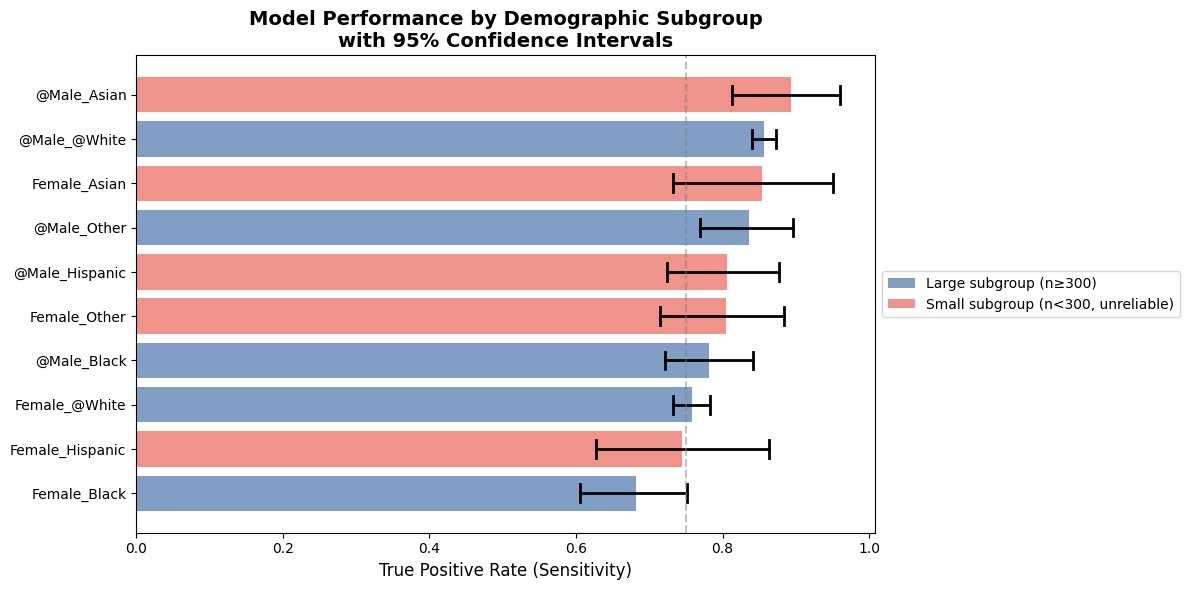


✓ Baseline model figure saved as 'baseline_subgroup_performance_ci.png'

BASELINE MODEL - SUMMARY STATISTICS

Overall Performance:
  Mean TPR: 0.802
  Std TPR: 0.063
  Min TPR: 0.682 (Female_Black)
  Max TPR: 0.893 (@Male_Asian)
  TPR Gap: 0.212

Reliable Subgroups (n≥300): 5/10
  Mean TPR: 0.783
  TPR Gap: 0.175

✓ Results saved to: baseline_subgroup_tpr_ci.csv


In [21]:
# ============================================================================
# BASELINE MODEL: SUBGROUP PERFORMANCE WITH CONFIDENCE INTERVALS
# ============================================================================

from scipy import stats

# ===== COMPUTE TPR WITH CI FUNCTION =====
def compute_tpr_ci(y_true, y_pred_bin, subgroup_mask):
    """Compute 95% CI for TPR in a subgroup using Wilson score interval"""
    y_true_sub = y_true[subgroup_mask.values]
    y_pred_sub = y_pred_bin[subgroup_mask.values]

    # TPR = TP / (TP + FN)
    positives = y_true_sub == 1
    n_pos = positives.sum()

    if n_pos == 0:
        return None, None, None, 0

    tp = ((y_true_sub == 1) & (y_pred_sub == 1)).sum()
    tpr = tp / n_pos

    # Wilson score interval for binomial proportion
    if n_pos < 5:  # Too small for reliable CI
        return tpr, np.nan, np.nan, n_pos

    ci = stats.binom.interval(0.95, n_pos, tpr)
    ci_lower, ci_upper = ci[0] / n_pos, ci[1] / n_pos

    return tpr, ci_lower, ci_upper, n_pos


# ===== PREPARE BASELINE PREDICTIONS =====
print("\n" + "="*80)
print("BASELINE MODEL - SUBGROUP ANALYSIS WITH CONFIDENCE INTERVALS")
print("="*80)

# Create Sex_Race column
dat_test_baseline = dat_test.copy()
dat_test_baseline["Sex_Race"] = (
    dat_test_baseline["sex"].astype(str) + "_" +
    dat_test_baseline["race"].astype(str)
)

# Get baseline predictions (already computed earlier)
y_true_baseline = dat_test_baseline["imv"].values
y_pred_bin_baseline = dat_test_baseline["pred_imv"].values  # From earlier analysis

print(f"✓ Using baseline predictions from earlier analysis")
print(f"✓ Baseline threshold: {optimal_threshold:.4f}")
print(f"✓ y_true shape: {y_true_baseline.shape}")
print(f"✓ y_pred_bin shape: {y_pred_bin_baseline.shape}")


# ===== COMPUTE TPR WITH CI FOR ALL SUBGROUPS =====
all_subgroups = sorted(dat_test_baseline['Sex_Race'].unique())

print(f"\nFound {len(all_subgroups)} unique subgroups in test set:")
print(all_subgroups)
print("\n" + "="*80)
print("BASELINE MODEL - TPR with 95% Confidence Intervals:")
print("="*80)

baseline_results = []
for subgroup in all_subgroups:
    mask = dat_test_baseline['Sex_Race'] == subgroup
    n_subgroup = mask.sum()

    tpr, ci_low, ci_high, n_pos = compute_tpr_ci(
        y_true_baseline,
        y_pred_bin_baseline,
        mask
    )

    if tpr is not None:
        baseline_results.append({
            'Subgroup': subgroup,
            'N_Total': n_subgroup,
            'N_Positive': n_pos,
            'TPR': tpr,
            'CI_Lower': ci_low,
            'CI_Upper': ci_high,
            'CI_Width': ci_high - ci_low if not np.isnan(ci_high) else np.nan
        })

        if not np.isnan(ci_low):
            print(f"{subgroup:25s} (n={n_subgroup:4d}, pos={n_pos:3d}): "
                  f"TPR={tpr:.3f} [{ci_low:.3f}, {ci_high:.3f}]")
        else:
            print(f"{subgroup:25s} (n={n_subgroup:4d}, pos={n_pos:3d}): "
                  f"TPR={tpr:.3f} [insufficient sample]")

# Convert to DataFrame
baseline_results_df = pd.DataFrame(baseline_results)
baseline_results_df = baseline_results_df.sort_values('TPR', ascending=True)


# ===== PLOT BASELINE MODEL WITH CIs =====
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(12, 6))

# Color code by sample size
colors_baseline = ['#E74C3C' if n < 300 else '#2E5F9E'
                   for n in baseline_results_df['N_Total']]

# Plot with error bars
y_pos = np.arange(len(baseline_results_df))
ax.barh(y_pos, baseline_results_df['TPR'], color=colors_baseline, alpha=0.6)

# Add confidence intervals
for i, row in enumerate(baseline_results_df.itertuples()):
    if not np.isnan(row.CI_Lower):
        ax.plot([row.CI_Lower, row.CI_Upper], [i, i], 'k-', linewidth=2)
        ax.plot([row.CI_Lower, row.CI_Lower], [i-0.2, i+0.2], 'k-', linewidth=2)
        ax.plot([row.CI_Upper, row.CI_Upper], [i-0.2, i+0.2], 'k-', linewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(baseline_results_df['Subgroup'])
ax.set_xlabel('True Positive Rate (Sensitivity)', fontsize=12)
ax.set_title('Model Performance by Demographic Subgroup\n' +
             'with 95% Confidence Intervals',
             fontsize=14, weight='bold')
ax.axvline(x=0.75, color='gray', linestyle='--', alpha=0.5,
           label='Reference threshold')

# Legend
legend_elements = [
    Patch(facecolor='#2E5F9E', alpha=0.6, label='Large subgroup (n≥300)'),
    Patch(facecolor='#E74C3C', alpha=0.6, label='Small subgroup (n<300, unreliable)')
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('baseline_subgroup_performance_ci.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Baseline model figure saved as 'baseline_subgroup_performance_ci.png'")


# ===== SUMMARY STATISTICS =====
print("\n" + "="*80)
print("BASELINE MODEL - SUMMARY STATISTICS")
print("="*80)

# Overall statistics
print(f"\nOverall Performance:")
print(f"  Mean TPR: {baseline_results_df['TPR'].mean():.3f}")
print(f"  Std TPR: {baseline_results_df['TPR'].std():.3f}")
print(f"  Min TPR: {baseline_results_df['TPR'].min():.3f} ({baseline_results_df.loc[baseline_results_df['TPR'].idxmin(), 'Subgroup']})")
print(f"  Max TPR: {baseline_results_df['TPR'].max():.3f} ({baseline_results_df.loc[baseline_results_df['TPR'].idxmax(), 'Subgroup']})")
print(f"  TPR Gap: {baseline_results_df['TPR'].max() - baseline_results_df['TPR'].min():.3f}")

# Subgroups with reliable estimates (n≥300)
reliable_groups = baseline_results_df[baseline_results_df['N_Total'] >= 300]
print(f"\nReliable Subgroups (n≥300): {len(reliable_groups)}/{len(baseline_results_df)}")
print(f"  Mean TPR: {reliable_groups['TPR'].mean():.3f}")
print(f"  TPR Gap: {reliable_groups['TPR'].max() - reliable_groups['TPR'].min():.3f}")

# Save results
baseline_results_df.to_csv('baseline_subgroup_tpr_ci.csv', index=False)
print(f"\n✓ Results saved to: baseline_subgroup_tpr_ci.csv")

#Correlation

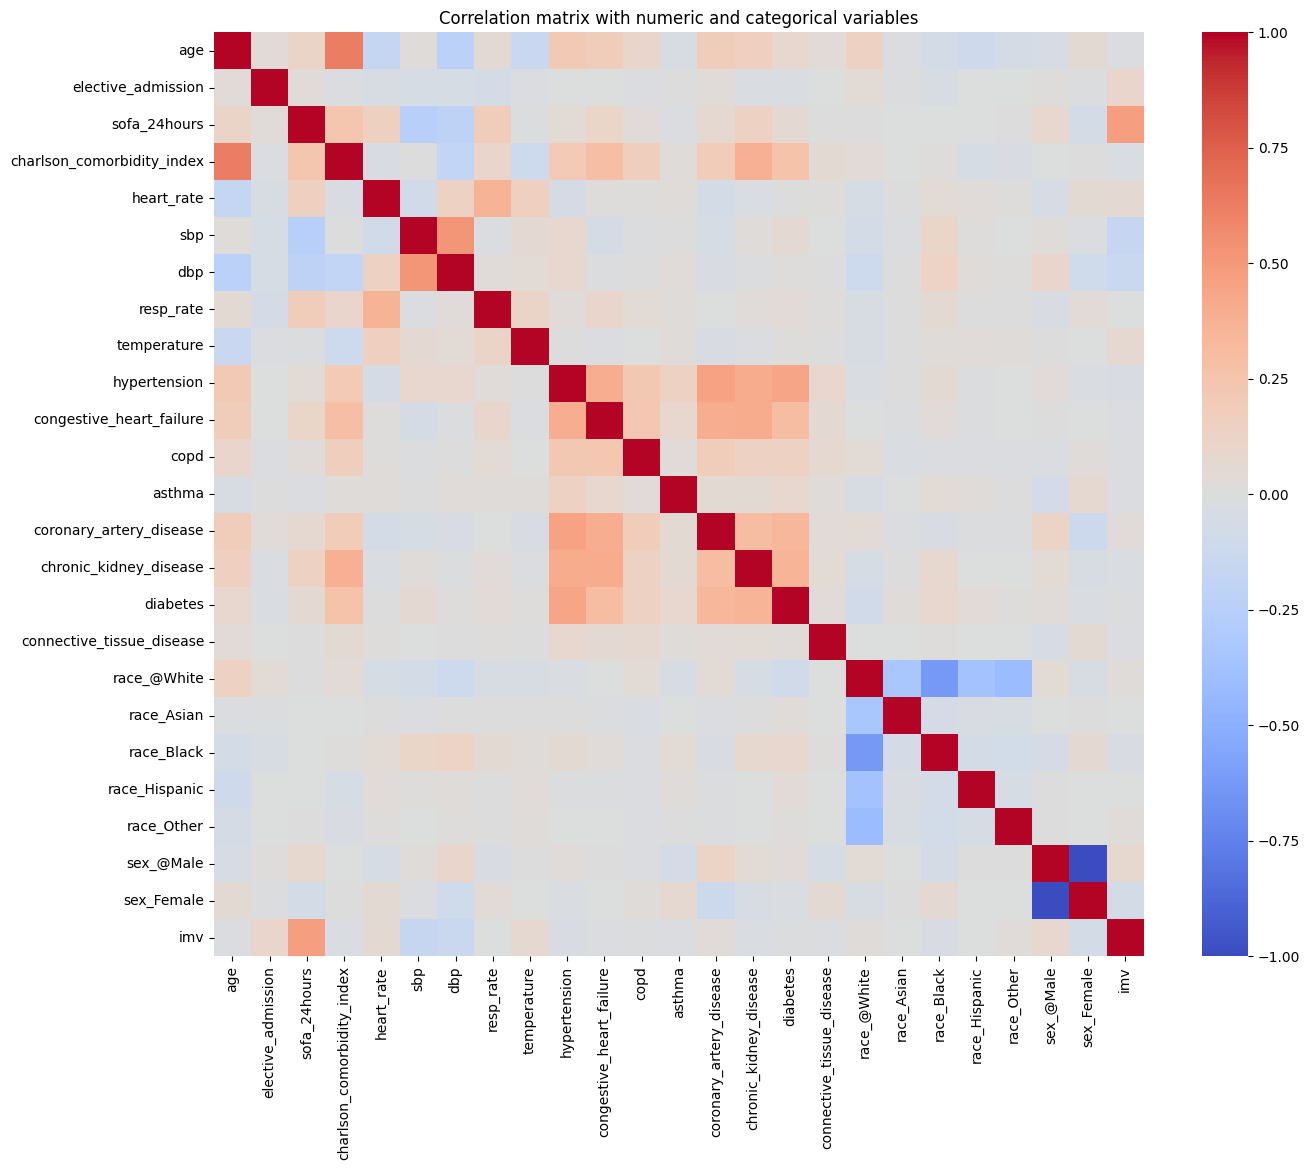

In [22]:
# Choose categorical columns
cat_cols = ['race', 'sex']

# One-hot encode categorical variables
df_cat_encoded = pd.get_dummies(dat_train[cat_cols], drop_first=False)  # keep all categories

# Combine with numeric columns
num_cols = [
    'age', 'elective_admission', 'sofa_24hours', 'charlson_comorbidity_index',
    'heart_rate', 'sbp', 'dbp', 'resp_rate', 'temperature'
] + list(conditions.keys()) + ['imv']

df_corr = pd.concat([dat_train[num_cols], df_cat_encoded], axis=1)
cols = [c for c in df_corr.columns if c != 'imv'] + ['imv']
df_corr = df_corr[cols]


# Compute correlation matrix
corr_matrix = df_corr.corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation matrix with numeric and categorical variables")
plt.show()

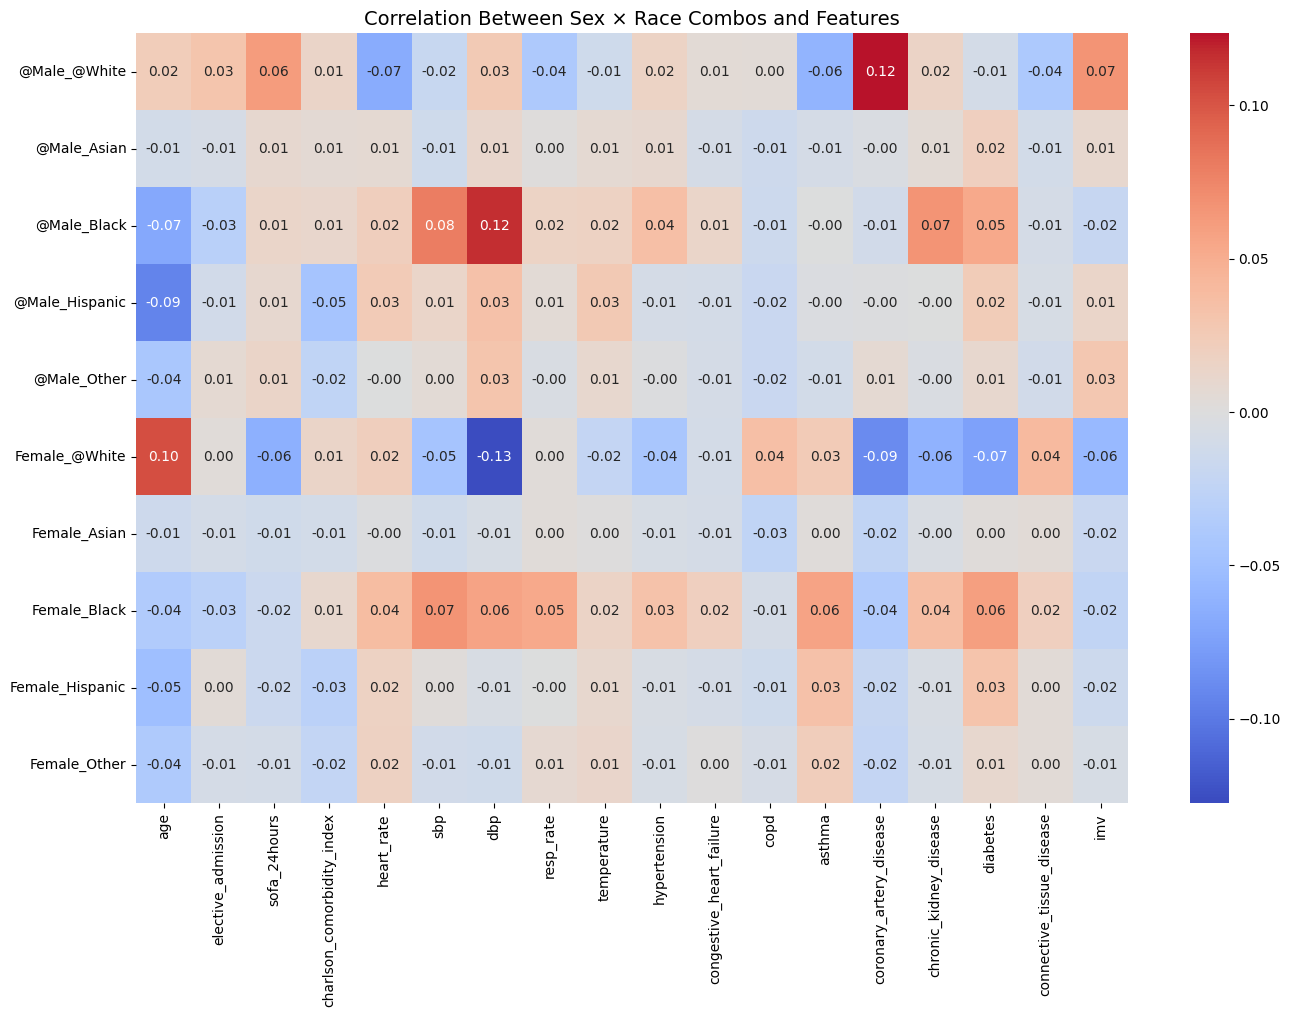

In [23]:
# Create Sex × Race combination
dat_train["Sex_Race"] = dat_train["sex"].astype(str) + "_" + dat_train["race"].astype(str)

# One-hot encode sex_Race
sex_race_encoded = pd.get_dummies(dat_train["Sex_Race"], prefix='', prefix_sep='')

# One-hot encode other categorical variables if needed
#cat_vars = ['language', 'insurance', 'marital_status']
#cat_encoded = pd.get_dummies(cohort[cat_vars], prefix='', prefix_sep='')

# Keep numeric columns
num_cols = [
    'age', 'elective_admission', 'sofa_24hours', 'charlson_comorbidity_index',
    'heart_rate', 'sbp', 'dbp', 'resp_rate', 'temperature'
] + list(conditions.keys())  # your comorbidities

# Combine all features
df_encoded = pd.concat([sex_race_encoded, dat_train[num_cols], dat_train[['imv']]], axis=1)

# Reorder so 'imv' is last
cols = [c for c in df_encoded.columns if c != 'imv'] + ['imv']
df_encoded = df_encoded[cols]

# Compute correlation between sex_Race and everything else
combo_cols = sex_race_encoded.columns.tolist()
corr_sub = df_encoded.corr().loc[combo_cols, df_encoded.columns.drop(combo_cols)]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_sub, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Between Sex × Race Combos and Features", fontsize=14)
plt.show()